In [2]:
import os
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from os.path import join as pjoin
from nod_utils import get_roi_data, ReceptiveFieldProcessor, save_ciftifile

# define plot utils
mpl.rcParams['axes.linewidth'] = 2
# mpl.rcParams.update({'font.size': 9, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams.update({'font.size': 9, 'font.family': 'Arial', 'mathtext.fontset': 'stix'})

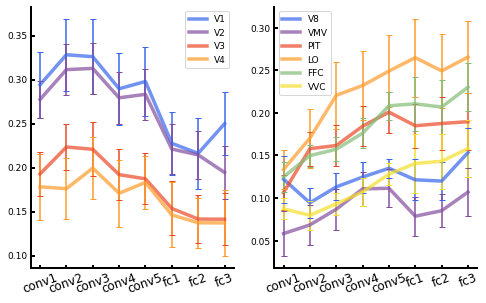

In [8]:
# ROI Acurary Across DNN Layers subject level
"""
extract_roi_performance support a threshold filter on quota
"""
def extract_roi_performance(sub_log, roi, quota=' lasso-test-cor'):
    '''return roi's mean std and number of voxels across layer'''
    if isinstance(roi, list):
        select_index = np.sum([(sub_log['roi'] == _).values for _ in roi], axis=0).astype(np.bool)
    else:
        select_index = (sub_log['roi'] == roi).values
    _df = sub_log.loc[select_index,:]
    # # filter
    # _df = _df.loc[_df[quota].values>0,:]
    desc_table = _df.groupby('layer')[quota].agg([np.mean, np.std])
    
    return desc_table['mean'].values, desc_table['std'].values, _df.shape[0]/8
# load record file
log_folder = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/code/nodanalysis/lasso_record'

load_sub = lambda x : pd.read_csv(pjoin(log_folder,f'{x}-clean_s4_dnn-based_prfmodel_fe-relu-top50_lassocv_record.log'))

subs = ['sub-01','sub-02','sub-03','sub-04','sub-05','sub-06','sub-08','sub-09','sub-10']
sub_logs = list(map(load_sub, subs))

# 
vtc_areas = ['V8','VMV', 'PIT','LO', 'FFC', 'VVC'] #['VMV1', 'VMV2', 'VMV3']
evc_areas = ['V1', 'V2', 'V3','V4']
roi_areas = [__  for _ in [evc_areas, vtc_areas] for __ in _]

#
fig, axs = plt.subplots(1, 2, figsize=(8,4.8))
i,j = 0,0
alpha = 0.7
lwidth = 2.5
quota_value = 'lasso-test-cor'
# colors = ['#E60965', '#FF8243', '#113CFC', '#610094',  '#83BD75', ]
colors = ['#3866ED','#824D9E','#EC4727', '#FE9B2A','#83BD75','#F5DF29','#D13655']
quota_value = 'lasso-test-cor'
error_denominator =  np.sqrt(len(sub_logs))
for _roi_ in roi_areas:
    means = []
    for sub_log in sub_logs:
        sub_log['cor_diff'] = sub_log['lasso-test-cor'] - sub_log['lr-test-cor']
        sub_log['r2_diff'] = sub_log['lasso-test-r2'] - sub_log['lr-test-r2']
        means.append(extract_roi_performance(sub_log, _roi_,quota_value)[0])
    means = np.array(means)
    if _roi_ in evc_areas:
        corr_line, corr_error = means.mean(axis=0), means.std(axis=0)
        axs[0].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=3.5, color=colors[i], alpha=alpha)
        axs[0].errorbar(np.arange(len(corr_line)), corr_line, corr_error/error_denominator, ls='None', color=colors[i], capsize=3)
        i = i + 1
    if _roi_ in vtc_areas:
        corr_line, corr_error = means.mean(axis=0), means.std(axis=0)
        if isinstance(_roi_, list):
            _roi_ = _roi_[0].strip('1')
        axs[1].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=3.5, color=colors[j], alpha=alpha)
        axs[1].errorbar(np.arange(len(corr_line)), corr_line, corr_error/error_denominator, ls='None',color=colors[j],capsize=3)
        j = j + 1
for ax in axs:
    ax.legend()
    ax.tick_params("both", width=2.0, direction='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    # ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6,7])#
    layer_label = ['conv1','conv2','conv3','conv4','conv5','fc1','fc2','fc3']
    ax.set_xticklabels(layer_label,rotation=20, fontsize=12)
    # ax.set_ylim([0,.12])
    # ax.set_xlim([-0.25,7.25])
plt.savefig('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodanalysis/figures/encoding_s4.jpg',dpi=300, bbox_inches='tight')
plt.show()

Plots lasso-test-cor
V1:150.0
V2:150.0
V3:150.0
V4:150.0
V8:150.0
PIT:150.0
FFC:150.0
VVC:150.0
VMV:450.0


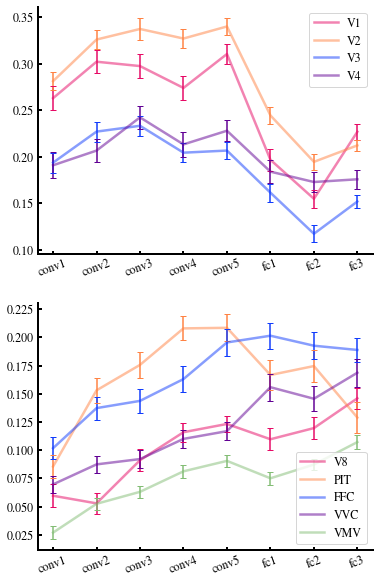

In [26]:
# ROI Acurary Across DNN Layers concate subject 
"""
extract_roi_performance support a threshold filter on quota
"""
def extract_roi_performance(sub_log, roi, quota=' lasso-test-cor'):
    '''return roi's mean std and number of voxels across layer'''
    _mask = get_roi_data(None, roi)
    _indices = np.where(_mask==1)[0]
    select_index = [ _ in _indices for _ in sub_log['voxel'] ]
    _df = sub_log.iloc[select_index,:]
    # # filter
    # _df = _df.loc[_df[quota].values>0,:]
    
    desc_table = _df.groupby('layer')[quota].agg([np.mean, np.std])
    
    return desc_table['mean'].values, desc_table['std'].values, _df.shape[0]/8
# load record file
log_folder = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/code/nodanalysis/lasso_record'
load_sub = lambda x : pd.read_csv(pjoin(log_folder,f'{x}_dnn-based_prfmodel_fe-relu-top50_lassocv_record.log'))

sub_log = pd.concat(tuple(map(load_sub, ['sub-01','sub-04','sub-08'])))
#
sub_log['cor_diff'] = sub_log['lasso-test-cor'] - sub_log['lr-test-cor']
sub_log['r2_diff'] = sub_log['lasso-test-r2'] - sub_log['lr-test-r2']
# 
vtc_areas = ['V8', 'PIT', 'FFC', 'VVC', ['VMV1', 'VMV2', 'VMV3']]
evc_areas = ['V1', 'V2', 'V3','V4']
roi_areas = [__  for _ in [evc_areas, vtc_areas] for __ in _]
#
fig, axs = plt.subplots(1, 2, figsize=(10,6))
i,j = 0,0
alpha = 0.5
lwidth = 2.5
quota_value = 'lasso-test-cor'
colors = ['#E60965', '#FF8243', '#113CFC', '#610094',  '#83BD75','#83BD75','#83BD75']
## 
print(f'Plots {quota_value}')
for _roi_ in roi_areas:
    if _roi_ in evc_areas:
        corr_line, corr_error, vox_num = extract_roi_performance(sub_log, _roi_, quota_value)
        axs[0].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=2.5, color=colors[i], alpha=alpha)
        axs[0].errorbar(np.arange(len(corr_line)), corr_line, corr_error/np.sqrt(vox_num), ls='None', color=colors[i], capsize=3)
        i = i + 1
        print(f'{_roi_}:{vox_num}')
    if _roi_ in vtc_areas:
        corr_line, corr_error, vox_num = extract_roi_performance(sub_log, _roi_, quota_value)
        if isinstance(_roi_, list):
            _roi_ = _roi_[0].strip('1')
        axs[1].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=2.5, color=colors[j], alpha=alpha)
        axs[1].errorbar(np.arange(len(corr_line)), corr_line, corr_error/np.sqrt(vox_num), ls='None',color=colors[j],capsize=3)
        j = j + 1
        print(f'{_roi_}:{vox_num}')
for ax in axs:
    ax.legend()
    ax.tick_params("both", width=2.0, direction='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    # ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6,7])#
    layer_label = ['conv1','conv2','conv3','conv4','conv5','fc1','fc2','fc3']
    ax.set_xticklabels(layer_label,rotation=20)
    # ax.set_ylim([0,.12])
    # ax.set_xlim([-0.25,7.25])
plt.show()

Plots lasso-test-cor
V1:50.0
V2:50.0
V3:50.0
V4:50.0
V8:50.0
PIT:50.0
VMV:50.0
LO:50.0
FFC:50.0
VVC:50.0


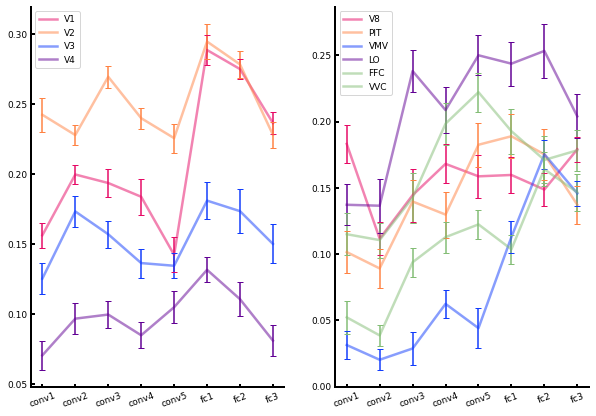

In [4]:
# ROI Acurary Across DNN Layers single subject
"""
extract_roi_performance support a threshold filter on quota
"""
def extract_roi_performance(sub_log, roi, quota=' lasso-test-cor'):
    '''return roi's mean std and number of voxels across layer'''
    if isinstance(roi, list):
        select_index = np.sum([(sub_log['roi'] == _).values for _ in roi], axis=0).astype(np.bool)
    else:
        select_index = (sub_log['roi'] == roi).values
    _df = sub_log.loc[select_index,:]
    # # filter
    # _df = _df.loc[_df[quota].values>0,:]
    desc_table = _df.groupby('layer')[quota].agg([np.mean, np.std])
    
    return desc_table['mean'].values, desc_table['std'].values, _df.shape[0]/8
# load record file
log_folder = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/code/nodanalysis/lasso_record'
# sub_log_conv = pd.read_csv(pjoin(log_folder,'sub-08_dnn-based_prfmodel_fe-relu_lassocv_record-conv.log'))
# sub_log_fc = pd.read_csv(pjoin(log_folder,'sub-08_dnn-based_prfmodel_fe-relu_lassocv_record-fc.log'))

# cvox_num = 2725
# sub_log_conv = sub_log_conv.iloc[0:int(cvox_num*5),:] # voxel with full layers in record
# sub_log_fc = sub_log_fc.iloc[0:int(cvox_num*3),:] # voxel with full layers in record

# sub_log = pd.concat((sub_log_fc, sub_log_conv)) sub-08_dnn-based_prfmodel_fe-relu-top50_lassocv_record
load_sub = lambda x : pd.read_csv(pjoin(log_folder,f'{x}_dnn-based_prfmodel_fe-relu-top50_lassocv_record.log'))
load_sub_s4 = lambda x : pd.read_csv(pjoin(log_folder,f'{x}-clean_s4_dnn-based_prfmodel_fe-relu-top50_lassocv_record.log'))

load = load_sub_s4
sub_log = load('sub-10')
#
sub_log['cor_diff'] = sub_log['lasso-test-cor'] - sub_log['lr-test-cor']
sub_log['r2_diff'] = sub_log['lasso-test-r2'] - sub_log['lr-test-r2']
# 
vtc_areas = ['V8', 'PIT', 'VMV', 'LO', 'FFC', 'VVC']#['VMV1', 'VMV2', 'VMV3']
evc_areas = ['V1', 'V2', 'V3','V4']
roi_areas = [__  for _ in [evc_areas, vtc_areas] for __ in _]
#
fig, axs = plt.subplots(1, 2, figsize=(10,7))
i,j = 0,0
alpha = 0.5
lwidth = 2.5
quota_value = 'lasso-test-cor'
colors = ['#E60965', '#FF8243', '#113CFC', '#610094',  '#83BD75','#83BD75','#83BD75']
## 
print(f'Plots {quota_value}')
for _roi_ in roi_areas:
    if _roi_ in evc_areas:
        corr_line, corr_error, vox_num = extract_roi_performance(sub_log, _roi_, quota_value)
        axs[0].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=2.5, color=colors[i], alpha=alpha)
        axs[0].errorbar(np.arange(len(corr_line)), corr_line, corr_error/np.sqrt(vox_num), ls='None', color=colors[i], capsize=3)
        i = i + 1
        print(f'{_roi_}:{vox_num}')
    if _roi_ in vtc_areas:
        corr_line, corr_error, vox_num = extract_roi_performance(sub_log, _roi_, quota_value)
        if isinstance(_roi_, list):
            _roi_ = _roi_[0].strip('1')
        axs[1].plot(np.arange(len(corr_line)), corr_line, label=_roi_, lw=2.5, color=colors[j], alpha=alpha)
        axs[1].errorbar(np.arange(len(corr_line)), corr_line, corr_error/np.sqrt(vox_num), ls='None',color=colors[j],capsize=3)
        j = j + 1
        print(f'{_roi_}:{vox_num}')
for ax in axs:
    ax.legend()
    ax.tick_params("both", width=2.0, direction='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    # ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6,7])#
    layer_label = ['conv1','conv2','conv3','conv4','conv5','fc1','fc2','fc3']
    ax.set_xticklabels(layer_label,rotation=20)
    # ax.set_ylim([0,.12])
    # ax.set_xlim([-0.25,7.25])
plt.show()

Plots lasso-test-cor
V1:50.0
V2:50.0
V3:50.0
V4:50.0
V8:50.0
PIT:50.0
VMV:50.0
LO:50.0
FFC:50.0
VVC:50.0


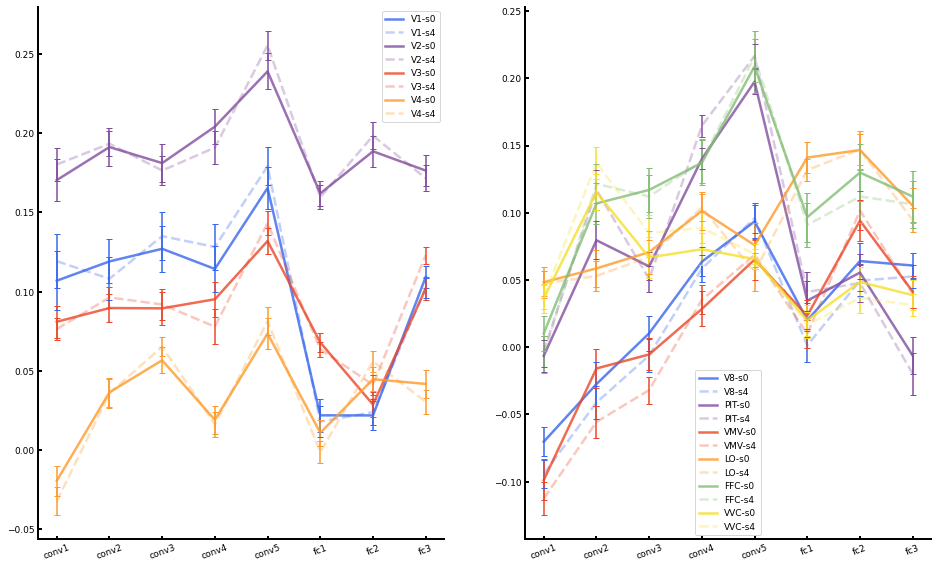

In [34]:
# comparing ROI Acurary Across DNN Layers of different in single subject
"""
extract_roi_performance support a threshold filter on quota
"""
def extract_roi_performance(sub_log, roi, quota=' lasso-test-cor'):
    '''return roi's mean std and number of voxels across layer'''
    if isinstance(roi, list):
        select_index = np.sum([(sub_log['roi'] == _).values for _ in roi], axis=0).astype(np.bool)
    else:
        select_index = (sub_log['roi'] == roi).values
    _df = sub_log.loc[select_index,:]
    # # filter
    # _df = _df.loc[_df[quota].values>0,:]
    desc_table = _df.groupby('layer')[quota].agg([np.mean, np.std])
    
    return desc_table['mean'].values, desc_table['std'].values, _df.shape[0]/8
# load record file
log_folder = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/code/nodanalysis/lasso_record'
# sub_log_conv = pd.read_csv(pjoin(log_folder,'sub-08_dnn-based_prfmodel_fe-relu_lassocv_record-conv.log'))
# sub_log_fc = pd.read_csv(pjoin(log_folder,'sub-08_dnn-based_prfmodel_fe-relu_lassocv_record-fc.log'))

# cvox_num = 2725
# sub_log_conv = sub_log_conv.iloc[0:int(cvox_num*5),:] # voxel with full layers in record
# sub_log_fc = sub_log_fc.iloc[0:int(cvox_num*3),:] # voxel with full layers in record

# sub_log = pd.concat((sub_log_fc, sub_log_conv)) sub-08_dnn-based_prfmodel_fe-relu-top50_lassocv_record
load_sub = lambda x : pd.read_csv(pjoin(log_folder,f'{x}_dnn-based_prfmodel_fe-relu-top50_lassocv_record.log'))
load_sub_s4 = lambda x : pd.read_csv(pjoin(log_folder,f'{x}-clean_s4_dnn-based_prfmodel_fe-relu-top50_lassocv_record.log'))

load = load_sub_s4
sub_log_s4 = load('sub-01')
#
sub_log_s4['cor_diff'] = sub_log_s4['lasso-test-cor'].values.astype(np.float32) - sub_log_s4['lr-test-cor'].values.astype(np.float32)
sub_log_s4['r2_diff'] = sub_log_s4['lasso-test-r2'].values.astype(np.float32) - sub_log_s4['lr-test-r2'].values.astype(np.float32)

load = load_sub
sub_log_s0 = load('sub-01')
#
sub_log_s0['cor_diff'] = sub_log_s0['lasso-test-cor'].values.astype(np.float32) - sub_log_s0['lr-test-cor'].values.astype(np.float32)
sub_log_s0['r2_diff'] = sub_log_s0['lasso-test-r2'].values.astype(np.float32) - sub_log_s0['lr-test-r2'].values.astype(np.float32)
# 
vtc_areas = ['V8', 'PIT', 'VMV', 'LO', 'FFC', 'VVC']#['VMV1', 'VMV2', 'VMV3']
evc_areas = ['V1', 'V2', 'V3','V4']
roi_areas = [__  for _ in [evc_areas, vtc_areas] for __ in _]
#
fig, axs = plt.subplots(1, 2, figsize=(16,9.8))
i,j = 0,0
alphas = [0.8, 0.3]
lwidth = 2.5
styles = ['-', '--']
labels = ['s0', 's4']
quota_value = 'lasso-test-cor'
colors = ['#3866ED','#824D9E','#EC4727', '#FE9B2A','#83BD75','#F5DF29','#D13655']
## 
print(f'Plots {quota_value}')
for _roi_ in roi_areas:
    if _roi_ in evc_areas:
        for k, sub_log in enumerate([sub_log_s0, sub_log_s4]):
            corr_line, corr_error, vox_num = extract_roi_performance(sub_log, _roi_, quota_value)
            axs[0].plot(np.arange(len(corr_line)), corr_line, label=f'{_roi_}-{labels[k]}', lw=lwidth, ls=styles[k], color=colors[i], alpha=alphas[k])
            axs[0].errorbar(np.arange(len(corr_line)), corr_line, corr_error/np.sqrt(vox_num), ls='None', color=colors[i], capsize=3)
        i = i + 1
        print(f'{_roi_}:{vox_num}')
    if _roi_ in vtc_areas:
        for k, sub_log in enumerate([sub_log_s0, sub_log_s4]):
            corr_line, corr_error, vox_num = extract_roi_performance(sub_log, _roi_, quota_value)
            axs[1].plot(np.arange(len(corr_line)), corr_line,  label=f'{_roi_}-{labels[k]}', lw=lwidth,  ls=styles[k], color=colors[j], alpha=alphas[k])
            axs[1].errorbar(np.arange(len(corr_line)), corr_line, corr_error/np.sqrt(vox_num), ls='None', color=colors[j], capsize=3)
        j = j + 1
        print(f'{_roi_}:{vox_num}')
for ax in axs:
    ax.legend()
    ax.tick_params("both", width=2.0, direction='in')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)
    # ax.set_yticklabels([])
    ax.set_xticks([0,1,2,3,4,5,6,7])#
    layer_label = ['conv1','conv2','conv3','conv4','conv5','fc1','fc2','fc3']
    ax.set_xticklabels(layer_label,rotation=20)
    # ax.set_ylim([0,.12])
    # ax.set_xlim([-0.25,7.25])
plt.show()

In [33]:
np.array(sub_log_s4['lasso-test-cor'])

array(['0.09618529291819113', '0.2718879617935561', '0.14872856799459894',
       ..., '0.11201550182636129', '0.07203233066505242',
       '0.06597484094658383'], dtype=object)

In [4]:
retino_folder = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodanalysis/spatial_summation_masks'
vucor_retino = np.load(pjoin(retino_folder,'sub-08_all-in-roi_spasum-mask-acrosslayermean-GMM-fe-relu.npy'), allow_pickle=True)[0]

In [5]:
sub = 'sub-08'
retino_path = '/nfs/z1/userhome/GongZhengXin/workingdir/code/retinotopy_matlab/results'
file_name = f'{sub}_retinotopy-allrun_params.mat'
retino_mat = sio.loadmat(pjoin(retino_path, file_name))['result']

mask = get_roi_data(None, roi_areas) 

n_vertices = np.sum(mask)
voxel_indices = np.where(mask==1)[0]
retinotopy_params = np.zeros((n_vertices, 3))
retinotopy_params[:,0] = retino_mat[0,0]['ang'][voxel_indices,0]
retinotopy_params[:,1] = retino_mat[0,0]['ecc'][voxel_indices,0]*16/200
retinotopy_params[:,2] = retino_mat[0,0]['rfsize'][voxel_indices,0]*16/200

# we need to transfer the params into (x,y,size) model
trans_retinotopy_params = np.zeros_like(retinotopy_params)
trans_retinotopy_params[:,0] = np.cos(retinotopy_params[:,0]/180*np.pi)*retinotopy_params[:,1]
trans_retinotopy_params[:,1] = np.sin(retinotopy_params[:,0]/180*np.pi)*retinotopy_params[:,1]
trans_retinotopy_params[:,2] = retinotopy_params[:,2]

In [6]:
v1_mask = get_roi_data(None, 'V1')
v1_indices = np.where(v1_mask==1)[0]
select_index = [ _ in v1_indices for _ in sub_log['voxel'] ]
v1_df = sub_log.iloc[select_index,:]

In [7]:
v1_df.loc[v1_df[' layer']=='conv1',' lasso-test-cor'].describe()

count    206.000000
mean       0.062974
std        0.113672
min       -0.213048
25%       -0.013049
50%        0.059799
75%        0.144955
max        0.317433
Name:  lasso-test-cor, dtype: float64

In [10]:
# v1_df.loc[v1_df[' layer']=='conv1','voxel'].values[np.abs(v1_df.loc[v1_df[' layer']=='conv1',' lasso-test-cor'].values - 0.059)<0.01]
v1_df.loc[v1_df[' layer']=='conv1','voxel'].values[v1_df.loc[v1_df[' layer']=='conv1',' lasso-test-cor'].values > 0.145]

array([   62, 21354, 21355, 21356, 21357, 21358, 21359, 21361, 21372,
       21373, 21890, 22027, 22028, 22029, 22030, 22069, 22070, 22073,
       22103, 22110, 22111, 22114, 22148, 22151, 22154, 22186, 22190,
       22224, 22231, 22260, 22264, 22265, 22266, 22298, 22299, 22300,
       22301, 22302, 22303, 22331, 22333, 22335, 22336, 22337, 22369,
       22370, 22371, 22401, 22404, 22405, 22433, 22438])

In [59]:
low=[   54,    55,    57,    58,   377,   395,   414,   431,   448,
         464,   479,   480,   481,   494, 21365, 21368, 21371, 21887,
       21888, 21931, 21932, 21933, 21937, 21938, 21939, 21975, 21976,
       21977, 21978, 21979, 22021, 22022, 22023, 22025, 22026, 22063,
       22064, 22066, 22067, 22068, 22104, 22105, 22106, 22107, 22108,
       22109, 22144, 22149, 22188, 22229, 22230, 22437]

medium=[   61,   450,   466, 21935, 21936, 21984, 22142, 22150, 22152,
       22189, 22222, 22258, 22267, 22366, 22373, 22432]
       
high=[   62, 21354, 21355, 21356, 21357, 21358, 21359, 21361, 21372,
       21373, 21890, 22027, 22028, 22029, 22030, 22069, 22070, 22073,
       22103, 22110, 22111, 22114, 22148, 22151, 22154, 22186, 22190,
       22224, 22231, 22260, 22264, 22265, 22266, 22298, 22299, 22300,
       22301, 22302, 22303, 22331, 22333, 22335, 22336, 22337, 22369,
       22370, 22371, 22401, 22404, 22405, 22433, 22438]
samples = [__ for _ in [low, medium, high] for __ in _]

Text(0.5, 0, 'rf size')

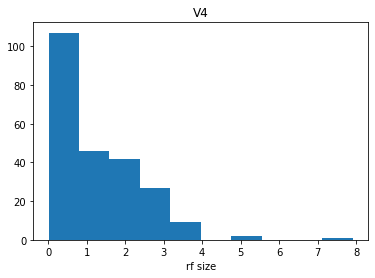

In [58]:
roi = 'V4'
v_mask = get_roi_data(None, roi)
v_indices = np.where(v_mask==1)[0]
select_index = [ _ in v_indices for _ in sub_log['voxel'] ]
v_df = sub_log.iloc[select_index,:]

V_voxels = [ np.where(voxel_indices == i)[0]  for i in v_df.loc[v_df[' layer']=='conv1','voxel'].values ]
plt.hist(trans_retinotopy_params[np.array(V_voxels),2])
plt.title(roi)
plt.xlabel('rf size')

voxel 61


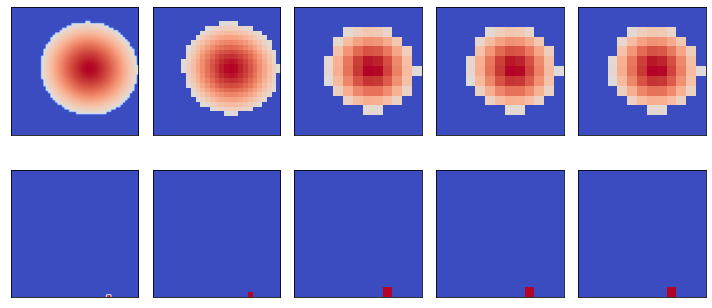

voxel 450


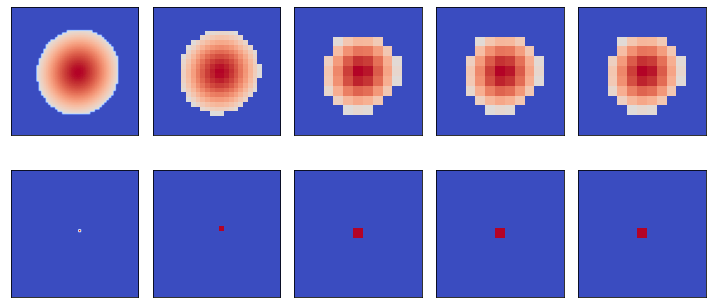

voxel 466


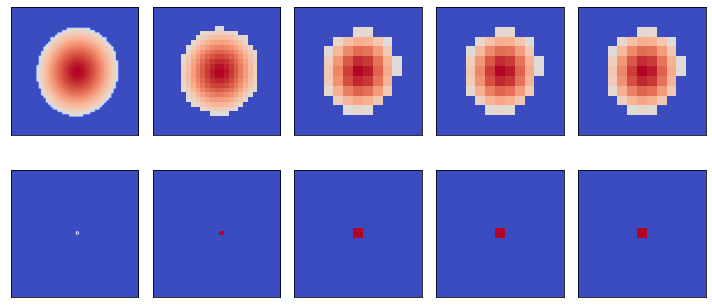

voxel 21935


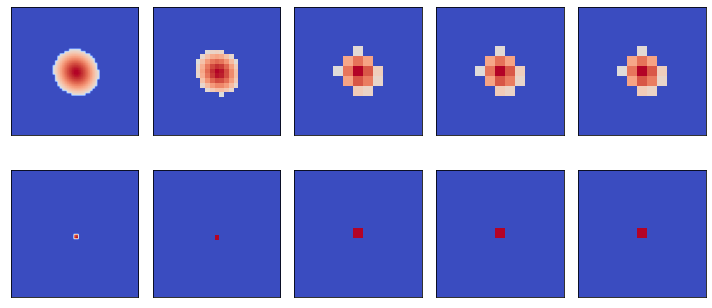

voxel 21936


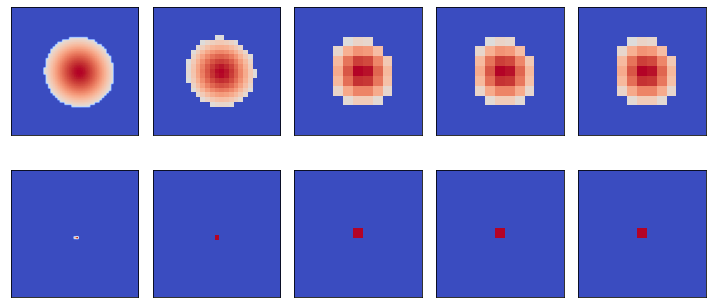

voxel 21984


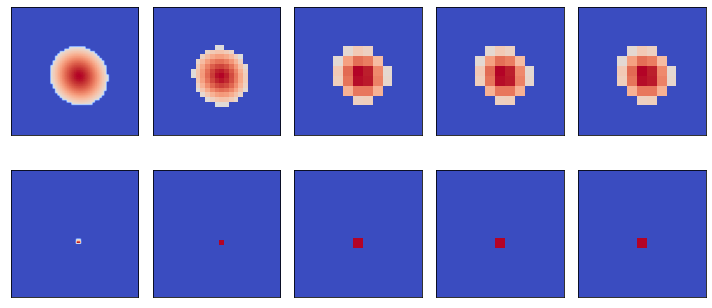

voxel 22142


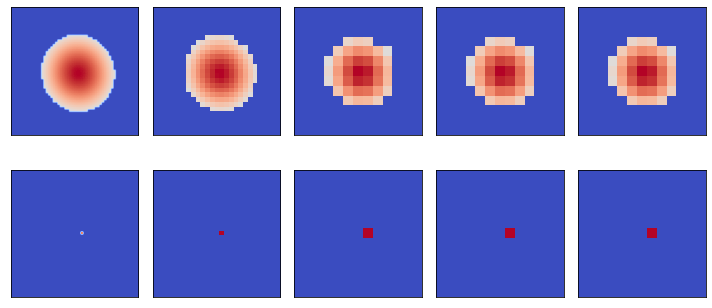

voxel 22150


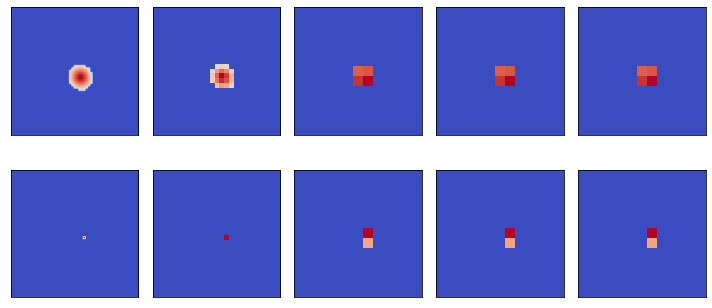

voxel 22152


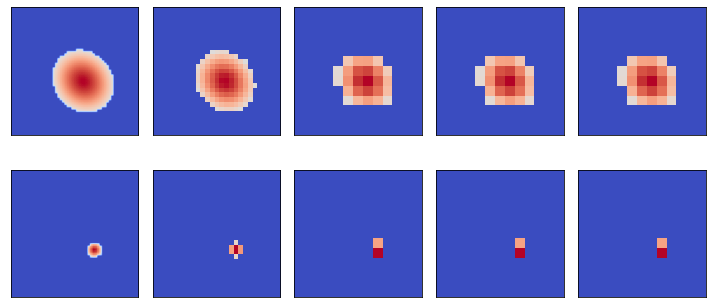

voxel 22189


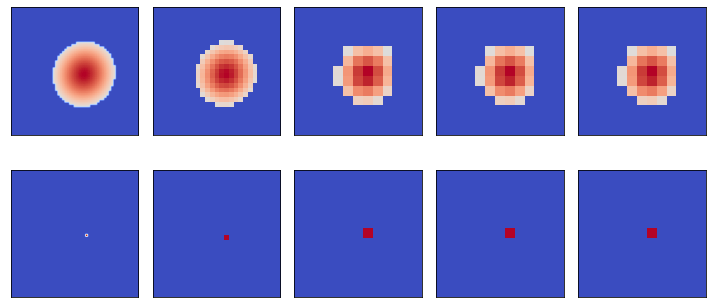

voxel 22222


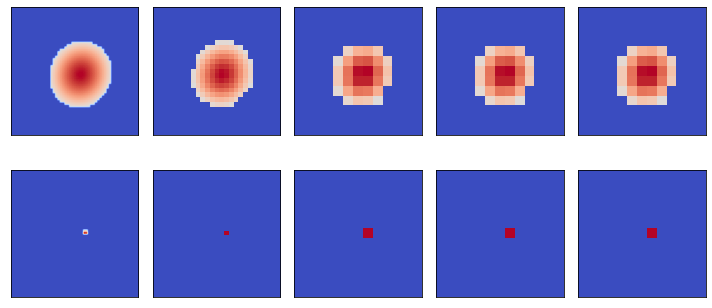

voxel 22258


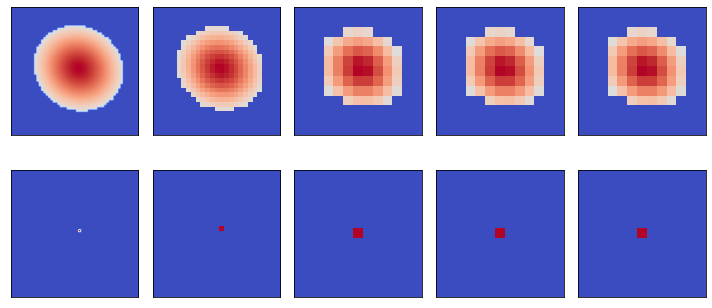

voxel 22267


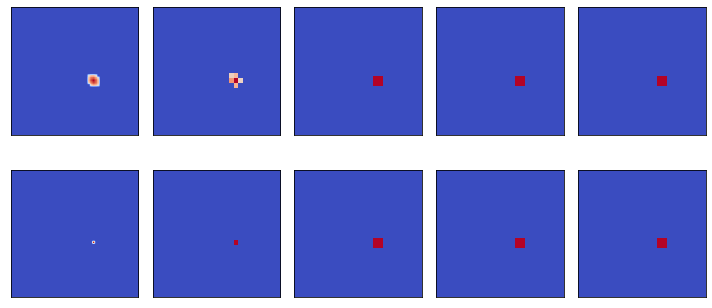

voxel 22366


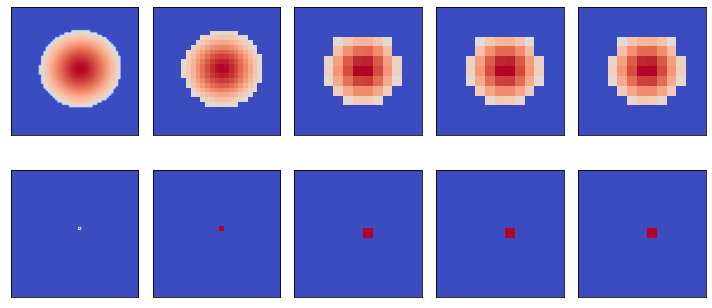

voxel 22373


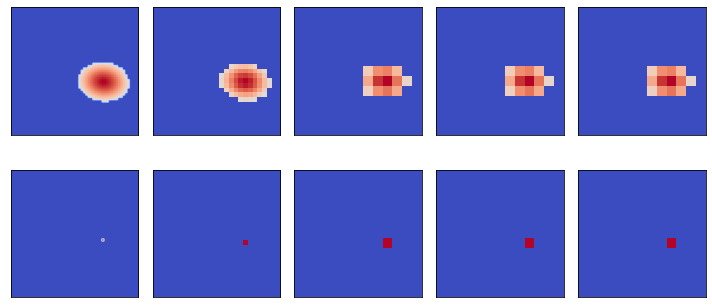

voxel 22432


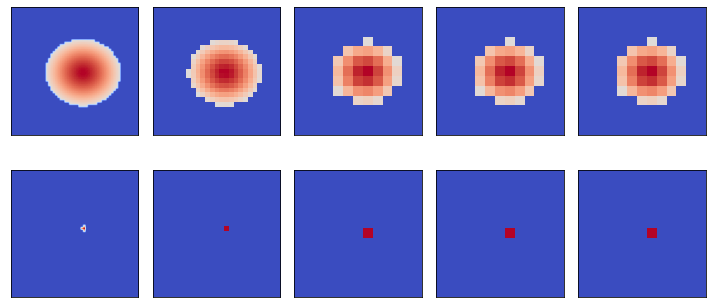

In [48]:
for i in medium:
    print(f'voxel {i}')
    voxel = np.where(voxel_indices == i)[0]
    spatial_maps = [ReceptiveFieldProcessor(16, trans_retinotopy_params[voxel,0],trans_retinotopy_params[voxel,1],trans_retinotopy_params[voxel,2]).get_spatial_kernel(_) for _ in [55,27,13,13,13]]
    weights = [(spatial_maps[i] >= 0.5*np.max(spatial_maps[i])) * spatial_maps[i] for i in range(5)]
    weights = [ weights[_]/(weights[_].sum()) for _ in range(5)] 
    vucor_maps = [vucor_retino[_][voxel,:,:] for _ in ['conv1','conv2','conv3','conv4','conv5']]
    fig, axs = plt.subplots(2,5,figsize=(10,5))
    for i in range(5):
        axs[0][i].imshow(np.squeeze(vucor_maps[i]), cmap='coolwarm')
        axs[0][i].set_xticks([])
        axs[0][i].set_yticks([])
    for j in range(5):
        axs[1][j].imshow(weights[j], cmap='coolwarm')
        axs[1][j].set_xticks([])
        axs[1][j].set_yticks([])
    plt.tight_layout()
    plt.show()

(array([ 1.,  4., 19., 21., 32., 34., 41., 38., 14.,  2.]),
 array([-0.19816066, -0.12056724, -0.04297383,  0.03461959,  0.11221301,
         0.18980642,  0.26739984,  0.34499326,  0.42258667,  0.50018009,
         0.57777351]),
 <BarContainer object of 10 artists>)

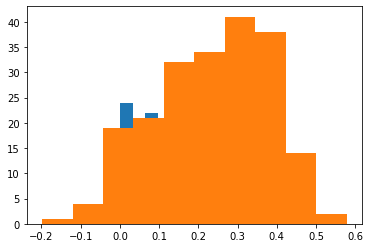